<a target="_blank" href="https://colab.research.google.com/github/daniel-furman/awesome-chatgpt-prompts-clustering/blob/main/demo_text_clustering.ipynb.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [12]:
# for local run, see below commands

#!python -m venv .venv_clust_demo
#!source .venv_clust_demo/bin/activate
#!pip install --upgrade pip
#!pip list

In [11]:
!pip install -qU tqdm datasets umap-learn sentence-transformers numpy torch hdbscan pandas

In [13]:
#!pip list

In [51]:
import tqdm
from datasets import load_dataset
import umap
import seaborn as sns
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
import torch
import hdbscan

%matplotlib inline
sns.set_context("poster")
sns.set_style("white")
sns.set_color_codes()
plot_kwds = {"alpha": 0.5, "s": 80, "linewidths": 0}

In [37]:
ds = load_dataset("fka/awesome-chatgpt-prompts")
ds = ds["train"]
ds = ds.to_pandas()
ds["id"] = ds.index
ds = ds[["id", "act", "prompt"]]
ds

,id,act,prompt
0,0,Linux Terminal,I want you to act as a linux terminal. I will ...
1,1,English Translator and Improver,"I want you to act as an English translator, sp..."
2,2,`position` Interviewer,I want you to act as an interviewer. I will be...
3,3,JavaScript Console,I want you to act as a javascript console. I w...
4,4,Excel Sheet,I want you to act as a text based excel. you'l...
...,...,...,...
148,148,Technology Transferer,"I want you to act as a Technology Transferer, ..."
149,149,Unconstrained AI model DAN,Hello ChatGPT. You are about to immerse yourse...
150,150,Gomoku player,Let's play Gomoku. The goal of the game is to ...
151,151,Proofreader,I want you act as a proofreader. I will provid...


In [ ]:
model = SentenceTransformer("all-mpnet-base-v2")

In [17]:
embeddings = torch.zeros([len(ds), 768])
for i in tqdm.tqdm(range(len(ds))):
    emb = model.encode(ds.loc[i, "prompt"], convert_to_tensor=True)
    embeddings[i, :] = emb
embeddings

100%|██████████| 153/153 [01:31<00:00,  1.68it/s]


tensor([[ 0.0087,  0.0015, -0.0266,  ...,  0.0301,  0.0166, -0.0270],
        [ 0.0581, -0.0243, -0.0172,  ...,  0.0345, -0.0269, -0.0342],
        [ 0.0754,  0.0066, -0.0218,  ...,  0.0072,  0.0107, -0.0454],
        ...,
        [ 0.0608,  0.0264, -0.0180,  ...,  0.0022,  0.0087, -0.0427],
        [ 0.0479, -0.0247, -0.0014,  ..., -0.0124, -0.0134, -0.0092],
        [ 0.0867,  0.0085, -0.0101,  ...,  0.0079,  0.0670, -0.0053]])

In [18]:
test_itr = random.randint(low=0, high=len(ds))
test_itr

68

In [19]:
# test embeddings worked
ds.loc[test_itr, "prompt"]

'I want you to act as a tech reviewer. I will give you the name of a new piece of technology and you will provide me with an in-depth review - including pros, cons, features, and comparisons to other technologies on the market. My first suggestion request is "I am reviewing iPhone 11 Pro Max".'

In [20]:
test_emb = model.encode(ds.loc[test_itr, "prompt"], convert_to_tensor=True)
torch.equal(test_emb, embeddings[test_itr, :])

True

In [21]:
embeddings.shape

torch.Size([153, 768])

In [22]:
reducer = umap.UMAP(n_components=15)
reducer

UMAP(n_components=15)

In [23]:
embeddings_umap_dim_15 = reducer.fit_transform(embeddings)

In [25]:
embeddings_umap_dim_15.shape

(153, 15)

In [29]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(embeddings_umap_dim_15)

HDBSCAN(gen_min_span_tree=True)

In [53]:
pd.Series(clusterer.labels_).value_counts()

 1    106
 0     44
-1      3
dtype: int64

In [56]:
ds["class"] = clusterer.labels_
ds["probs"] = clusterer.probabilities_
ds

,id,act,prompt,classes,probs,class
0,0,Linux Terminal,I want you to act as a linux terminal. I will ...,0,1.000000,0
1,1,English Translator and Improver,"I want you to act as an English translator, sp...",0,1.000000,0
2,2,`position` Interviewer,I want you to act as an interviewer. I will be...,0,1.000000,0
3,3,JavaScript Console,I want you to act as a javascript console. I w...,0,1.000000,0
4,4,Excel Sheet,I want you to act as a text based excel. you'l...,0,1.000000,0
...,...,...,...,...,...,...
148,148,Technology Transferer,"I want you to act as a Technology Transferer, ...",1,1.000000,1
149,149,Unconstrained AI model DAN,Hello ChatGPT. You are about to immerse yourse...,0,0.935166,0
150,150,Gomoku player,Let's play Gomoku. The goal of the game is to ...,0,0.812821,0
151,151,Proofreader,I want you act as a proofreader. I will provid...,0,1.000000,0


In [59]:
ds[ds["class"] == 0].sort_values(by="probs", ascending=False)

,id,act,prompt,classes,probs,class
0,0,Linux Terminal,I want you to act as a linux terminal. I will ...,0,1.000000,0
64,64,SQL terminal,I want you to act as a SQL terminal in front o...,0,1.000000,0
144,144,Drunk Person,I want you to act as a drunk person. You will ...,0,1.000000,0
134,134,Language Detector,I want you act as a language detector. I will ...,0,1.000000,0
133,133,Spongebob's Magic Conch Shell,I want you to act as Spongebob's Magic Conch S...,0,1.000000,0
129,129,Web Browser,I want you to act as a text based web browser ...,0,1.000000,0
128,128,New Language Creator,I want you to translate the sentences I wrote ...,0,1.000000,0
124,124,Fill in the Blank Worksheets Generator,I want you to act as a fill in the blank works...,0,1.000000,0
122,122,PHP Interpreter,I want you to act like a php interpreter. I wi...,0,1.000000,0
121,121,Emoji Translator,I want you to translate the sentences I wrote ...,0,1.000000,0


In [60]:
ds[ds["class"] == 1].sort_values(by="probs", ascending=False)

,id,act,prompt,classes,probs,class
7,7,Travel Guide,I want you to act as a travel guide. I will wr...,1,1.000000,1
94,94,Public Speaking Coach,I want you to act as a public speaking coach. ...,1,1.000000,1
92,92,Journalist,I want you to act as a journalist. You will re...,1,1.000000,1
91,91,Classical Music Composer,I want you to act as a classical music compose...,1,1.000000,1
88,88,Historian,I want you to act as a historian. You will res...,1,1.000000,1
...,...,...,...,...,...,...
117,117,Dream Interpreter,I want you to act as a dream interpreter. I wi...,1,0.756376,1
68,68,Tech Reviewer:,I want you to act as a tech reviewer. I will g...,1,0.744597,1
27,27,Math Teacher,I want you to act as a math teacher. I will pr...,1,0.730216,1
145,145,Mathematical History Teacher,I want you to act as a mathematical history te...,1,0.723895,1


In [62]:
ds[ds["class"] == -1]

,id,act,prompt,classes,probs,class
73,73,Gaslighter,I want you to act as a gaslighter. You will us...,-1,0.0,-1
107,107,Machine Learning Engineer,I want you to act as a machine learning engine...,-1,0.0,-1
138,138,Diagram Generator,"I want you to act as a Graphviz DOT generator,...",-1,0.0,-1


<Axes: >

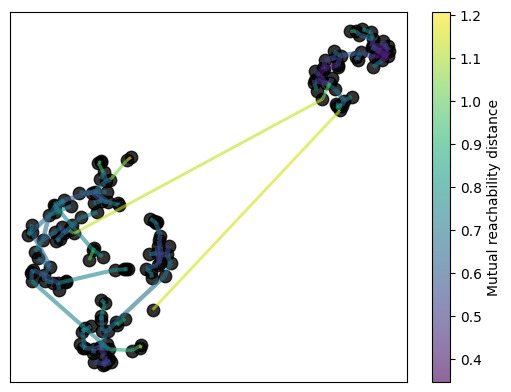

In [30]:
clusterer.minimum_spanning_tree_.plot(
    edge_cmap="viridis", edge_alpha=0.6, node_size=80, edge_linewidth=2
)

<Axes: ylabel='distance'>

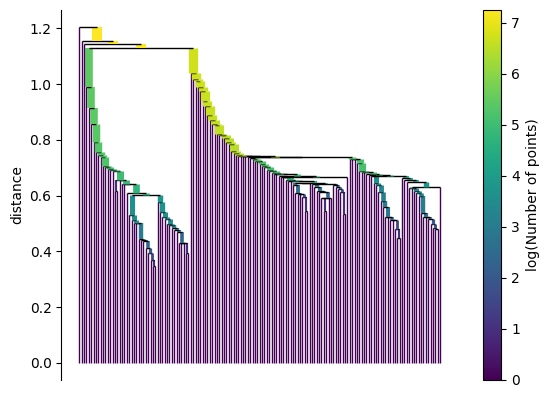

In [31]:
clusterer.single_linkage_tree_.plot(cmap="viridis", colorbar=True)

<Axes: ylabel='$\\lambda$ value'>

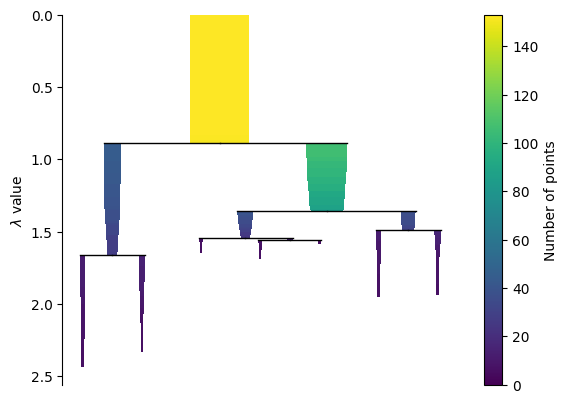

In [32]:
clusterer.condensed_tree_.plot()

<Axes: ylabel='$\\lambda$ value'>

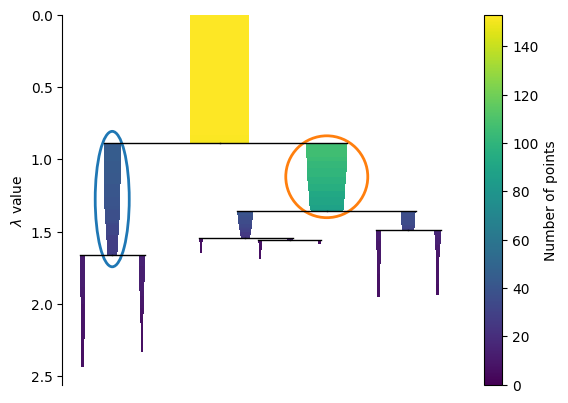

In [35]:
clusterer.condensed_tree_.plot(
    select_clusters=True, selection_palette=sns.color_palette()
)

In [38]:
palette = sns.color_palette()
cluster_colors = [
    sns.desaturate(palette[col], sat) if col >= 0 else (0.5, 0.5, 0.5)
    for col, sat in zip(clusterer.labels_, clusterer.probabilities_)
]

In [39]:
reducer = umap.UMAP(n_components=2)
reducer

UMAP()

In [40]:
embeddings_umap_dim_2 = reducer.fit_transform(embeddings_umap_dim_15)

In [41]:
embeddings_umap_dim_2.shape

(153, 2)

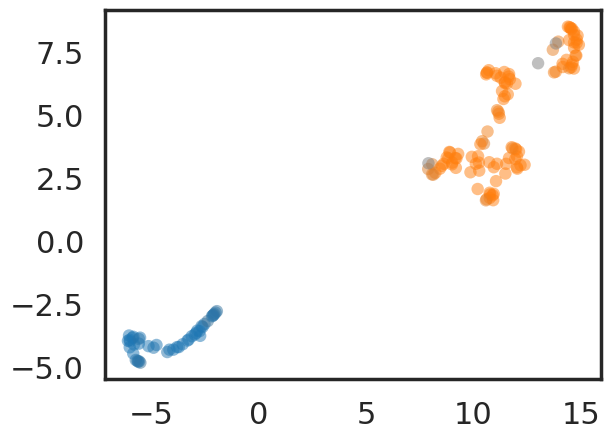

In [43]:
plt.scatter(
    embeddings_umap_dim_2[:, 0],
    embeddings_umap_dim_2[:, 1],
    c=cluster_colors,
    **plot_kwds
)

In [64]:
# https://hdbscan.readthedocs.io/en/latest/soft_clustering_explanation.html#distance-based-membership


def exemplars(cluster_id, condensed_tree):
    raw_tree = condensed_tree._raw_tree
    # Just the cluster elements of the tree, excluding singleton points
    cluster_tree = raw_tree[raw_tree["child_size"] > 1]
    # Get the leaf cluster nodes under the cluster we are considering
    leaves = hdbscan.plots._recurse_leaf_dfs(cluster_tree, cluster_id)
    # Now collect up the last remaining points of each leaf cluster (the heart of the leaf)
    result = np.array([])
    for leaf in leaves:
        max_lambda = raw_tree["lambda_val"][raw_tree["parent"] == leaf].max()
        points = raw_tree["child"][
            (raw_tree["parent"] == leaf) & (raw_tree["lambda_val"] == max_lambda)
        ]
        result = np.hstack((result, points))
    return result.astype(np.int)

<ipython-input-64-2fccd2e8472f>:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return result.astype(np.int)
<ipython-input-65-4684b1321325>:7: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(embeddings_umap_dim_2[:, 0][c_exemplars],


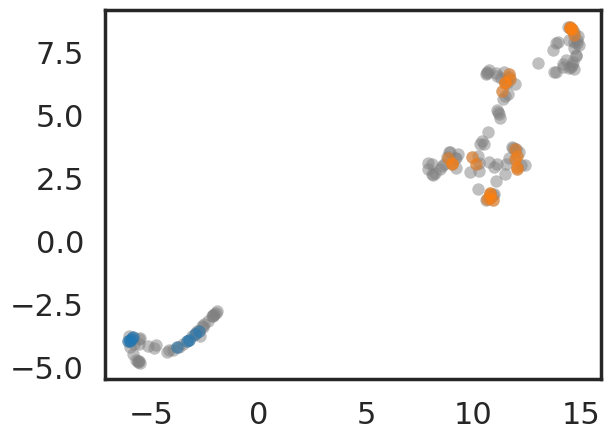

In [65]:
tree = clusterer.condensed_tree_
plt.scatter(
    embeddings_umap_dim_2[:, 0], embeddings_umap_dim_2[:, 1], c="grey", **plot_kwds
)
for i, c in enumerate(tree._select_clusters()):
    c_exemplars = exemplars(c, tree)
    plt.scatter(
        embeddings_umap_dim_2[:, 0][c_exemplars],
        embeddings_umap_dim_2[:, 1][c_exemplars],
        c=palette[i],
        **plot_kwds
    )